# Digits recognition with Neural Networks

In this project I will compare three models that recognizes handwritten digits: 
* Standard Neural Network, 
* Convolutional Neural Network 
* and SGD Classification model.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Flatten
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


Let's check that GPU is working:

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 580934593798183338, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6662668288
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4353266478686519621
 physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"]

## About the data

The MNIST database contains 60,000 training images and 10,000 testing images of digits written by high school students and employees of the United States Census Bureau.

In [3]:
from keras.datasets import mnist

(X, y), (X_test, y_test) = mnist.load_data()

In [4]:
X.shape

(60000, 28, 28)

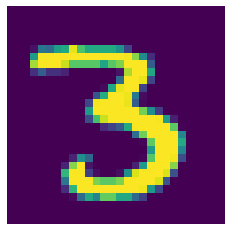

In [5]:
plt.imshow(X[12])
plt.axis("off")
plt.show()

In [6]:
y[12]

3

# Standard Neural Network


#### Preprocessing

In [7]:
(X, y), (X_test, y_test) = mnist.load_data()

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)

# Vectorizing images
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
X_val = X_val.reshape(X_val.shape[0], num_pixels).astype('float32')

# Normalizing
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
X_val = X_val / X_val.max()

# One hot encoding outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

#### Evaluation metrics

Since Keras have removed f1 score I will create a custom one:

In [8]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Training a model

In [9]:
def create_classification_model():
    model = Sequential()
    model.add(Dense(num_pixels, activation="relu", input_shape=(num_pixels, )))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(y_train.shape[1], activation="softmax"))    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', f1])
    return model

In [10]:
model = create_classification_model()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
 - 6s - loss: 0.2780 - accuracy: 0.9162 - f1: 0.9122 - val_loss: 0.1400 - val_accuracy: 0.9587 - val_f1: 0.9593
Epoch 2/15
 - 6s - loss: 0.0942 - accuracy: 0.9721 - f1: 0.9723 - val_loss: 0.1048 - val_accuracy: 0.9689 - val_f1: 0.9693
Epoch 3/15
 - 6s - loss: 0.0638 - accuracy: 0.9801 - f1: 0.9804 - val_loss: 0.1132 - val_accuracy: 0.9668 - val_f1: 0.9682
Epoch 4/15
 - 6s - loss: 0.0455 - accuracy: 0.9860 - f1: 0.9861 - val_loss: 0.0989 - val_accuracy: 0.9729 - val_f1: 0.9729
Epoch 5/15
 - 6s - loss: 0.0371 - accuracy: 0.9881 - f1: 0.9882 - val_loss: 0.1220 - val_accuracy: 0.9682 - val_f1: 0.9680
Epoch 6/15
 - 6s - loss: 0.0306 - accuracy: 0.9899 - f1: 0.9900 - val_loss: 0.1336 - val_accuracy: 0.9692 - val_f1: 0.9692
Epoch 7/15
 - 6s - loss: 0.0256 - accuracy: 0.9919 - f1: 0.9918 - val_loss: 0.1067 - val_accuracy: 0.9734 - val_f1: 0.9736
Epoch 8/15
 - 6s - loss: 0.0215 - accuracy: 0.9931 - f1: 0.9933 - val_loss: 0.1045 - val_

In [11]:
scores = model.evaluate(X_test, y_test, verbose=0)
accuracy, f1_scores = scores[1], scores[2]
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('F1: {:.2f}%'.format(f1_scores*100))

Accuracy: 98.13%
F1: 98.15%


Very good. Now let's see what Convolutional NN can show

# Convolutional Neural Network (CNN)

#### Preprocessing

In [12]:
(X, y), (X_test, y_test) = mnist.load_data()

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)

# 4D reshape
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Normalizing
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
X_val = X_val / X_val.max()

# One hot encoding outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

#### Training a model

In [13]:
num_classes = y_train.shape[1]

def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5,5), activation="relu", input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(64, kernel_size=(2,2), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', f1])
    return model

In [14]:
cnn_model = create_cnn_model()

In [15]:
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=200, epochs=15, verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
 - 3s - loss: 0.3166 - accuracy: 0.9130 - f1: 0.8797 - val_loss: 0.1043 - val_accuracy: 0.9687 - val_f1: 0.9691
Epoch 2/15
 - 2s - loss: 0.0759 - accuracy: 0.9771 - f1: 0.9772 - val_loss: 0.0796 - val_accuracy: 0.9758 - val_f1: 0.9766
Epoch 3/15
 - 2s - loss: 0.0513 - accuracy: 0.9847 - f1: 0.9848 - val_loss: 0.0620 - val_accuracy: 0.9816 - val_f1: 0.9820
Epoch 4/15
 - 2s - loss: 0.0415 - accuracy: 0.9874 - f1: 0.9876 - val_loss: 0.0560 - val_accuracy: 0.9829 - val_f1: 0.9826
Epoch 5/15
 - 2s - loss: 0.0336 - accuracy: 0.9895 - f1: 0.9895 - val_loss: 0.0523 - val_accuracy: 0.9844 - val_f1: 0.9844
Epoch 6/15
 - 2s - loss: 0.0278 - accuracy: 0.9915 - f1: 0.9916 - val_loss: 0.0464 - val_accuracy: 0.9856 - val_f1: 0.9857
Epoch 7/15
 - 2s - loss: 0.0248 - accuracy: 0.9922 - f1: 0.9922 - val_loss: 0.0468 - val_accuracy: 0.9869 - val_f1: 0.9869
Epoch 8/15
 - 2s - loss: 0.0202 - accuracy: 0.9938 - f1: 0.9938 - val_loss: 0.0457 - val_

In [16]:
scores = cnn_model.evaluate(X_test, y_test, verbose=0)
accuracy, f1_scores = scores[1], scores[2]
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('F1: {:.2f}%'.format(f1_scores*100))

Accuracy: 99.07%
F1: 99.09%


CNN is three times faster and shows two times smaller loss than the standard one. 

#### Confusion analize

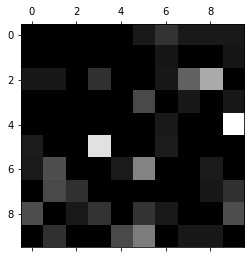

Rows are Test values and columns are Predicted.


In [17]:
y_pred = cnn_model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]  # reverse O-H-Encoding
y_test = [np.argmax(x) for x in y_test]

conf_mx = confusion_matrix(y_test, y_pred)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
print("Rows are Test values and columns are Predicted.")

Most confusions are with 5 which classified as 3. Also, some 9 were classified as 3 and 4


Let's see 5, 8 and 9 digits

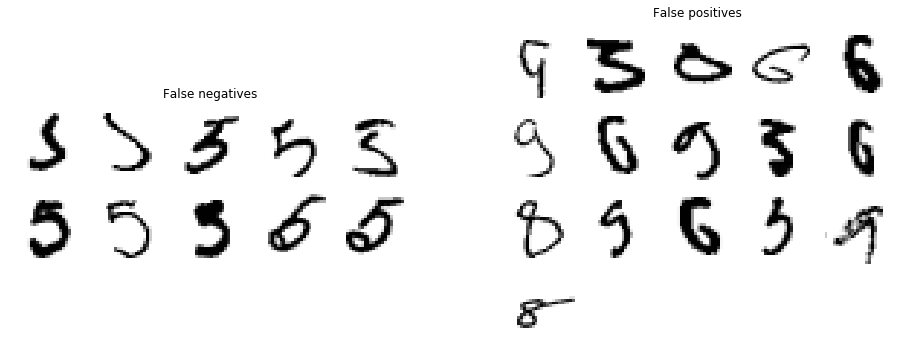

In [18]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

    
digit = 5
true_idxs = [idx for idx, x in enumerate(y_test) if x==digit]
false_neg_idxs = [idx for idx in true_idxs if y_pred[idx]!=digit]
false_pos_idxs = [idx for idx, x in enumerate(y_pred) if (idx not in true_idxs) & (y_pred[idx]==digit)]

plt.figure(figsize=(16,16))
plt.subplot(121); plt.title("False negatives"); plot_digits(X_test[false_neg_idxs], images_per_row=5)
plt.subplot(122); plt.title("False positives"); plot_digits(X_test[false_pos_idxs], images_per_row=5)
plt.show()

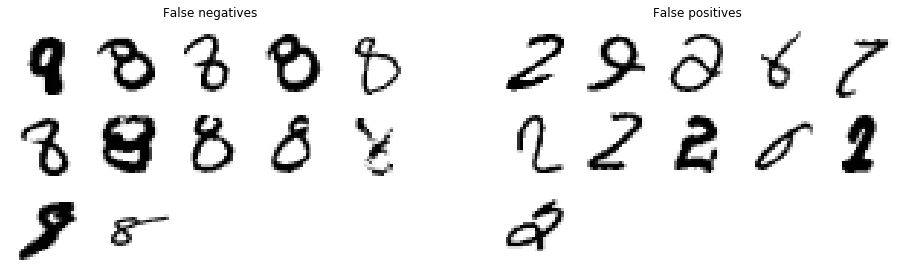

In [19]:
digit = 8
true_idxs = [idx for idx, x in enumerate(y_test) if x==digit]
false_neg_idxs = [idx for idx in true_idxs if y_pred[idx]!=digit]
false_pos_idxs = [idx for idx, x in enumerate(y_pred) if (idx not in true_idxs) & (y_pred[idx]==digit)]

plt.figure(figsize=(16,16))
plt.subplot(121); plt.title("False negatives"); plot_digits(X_test[false_neg_idxs], images_per_row=5)
plt.subplot(122); plt.title("False positives"); plot_digits(X_test[false_pos_idxs], images_per_row=5)
plt.show()

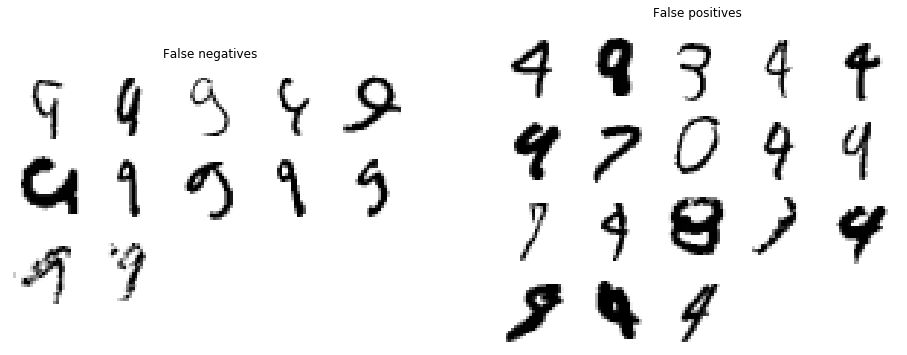

In [20]:
digit = 9
true_idxs = [idx for idx, x in enumerate(y_test) if x==digit]
false_neg_idxs = [idx for idx in true_idxs if y_pred[idx]!=digit]
false_pos_idxs = [idx for idx, x in enumerate(y_pred) if (idx not in true_idxs) & (y_pred[idx]==digit)]

plt.figure(figsize=(16,16))
plt.subplot(121); plt.title("False negatives"); plot_digits(X_test[false_neg_idxs], images_per_row=5)
plt.subplot(122); plt.title("False positives"); plot_digits(X_test[false_pos_idxs], images_per_row=5)
plt.show()

Some cases are hard to recognize even for a human. But still, there is a place for improvement

# SGD Classification model

Finally, just to compare with NN I will build a simple classification model

In [21]:
(X, y), (X_test, y_test) = mnist.load_data()

# Vectorization
X_train = X.reshape(X.shape[0], num_pixels)
X_test = X_train.reshape(X_train.shape[0], num_pixels)

# Normalizing
X_train = X_train / X_train.max()

In [22]:
def print_scores(score):
    print("Accuracy:  {:0.2f}%".format(100*score['test_accuracy'].mean()))
    print("F1 score:  {:0.2f}%".format(100*score['test_f1'].mean()))
    
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average="weighted")
}

In [23]:
clf_model = SGDClassifier(random_state=11)
score = cross_validate(clf_model, X_train, y, cv=3, verbose=3, scoring=scoring, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s finished


In [24]:
print_scores(score)

Accuracy:  90.65%
F1 score:  90.61%


Good results. Still, it mistakes 10 times more often than CNN does

## Save the model

In [25]:
cnn_model.save('mnist_nn.h5')